In [4]:
import os
import dspy
from autometrics.autometrics import Autometrics
from autometrics.dataset.datasets.simplification.simplification import SimpDA
from autometrics.aggregator.regression.ElasticNet import ElasticNet
import pandas as pd
from autometrics.dataset.Dataset import Dataset

# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = open('/Users/spangher/.openai-reglab-project-key.txt').read().strip()

def downsample_df(df: pd.DataFrame, label_col: str = "c", random_state: int | None = 42) -> pd.DataFrame:
    """
    Downsample a DataFrame so each label in `label_col` has the same number of rows.
    The function finds the smallest class size and randomly samples that many rows from
    every label bucket. Useful for balancing binary (0/1) human-selection labels.
    Args:
        df: Input DataFrame containing a label column.
        label_col: Name of the column whose classes should be balanced.
        random_state: Optional seed for reproducible sampling.
    Returns:
        A new DataFrame with equal counts per label.
    """
    if label_col not in df.columns:
        raise ValueError(f"Column '{label_col}' not found in DataFrame.")
    label_counts = df[label_col].value_counts(dropna=False)
    if label_counts.empty:
        return df.copy()
    min_count = label_counts.min()
    balanced = (
        df.groupby(label_col, group_keys=False)
        .apply(lambda group: group.sample(n=min_count, random_state=random_state))
        .reset_index(drop=True)
    )
    return balanced

/Users/spangher/miniconda3/lib/python3.12/site-packages/pyemd/__init__.py:74: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from .emd import emd, emd_with_flow, emd_samples


[Autometrics] No GPU detected - using BM25 + LLMRec pipeline for CPU-optimized performance


In [42]:
df = pd.read_csv('full_matched_comment_df__omb-pr.csv', index_col=0)

In [77]:
dataset_pr = Dataset(
    dataframe=downsample_df(df.loc[lambda df: df['collection_id'] == 'PR-02-2023']),
    target_columns=['c'],
    ignore_columns=['doc_id', 'collection_id', 'content_of_comment', 'response_to_comment'],
    metric_columns=[],
    name="MyCustomDataset_PR",
    data_id_column="doc_id",
    input_column=['call'],
    output_column="text",#, "comment_summary"],
    # output_column=["text"],#, "comment_summary"],
    # output_column="c",
    task_description="""Rank candidate policy feedback drafts for follow-up: given a citizen’s submission, 
    determine which responses merit escalation to agency officials.""",
)

dataset_omb = Dataset(
    dataframe=downsample_df(df.loc[lambda df: df['collection_id'] == 'OMB-2023-0020']),
    target_columns=['c'],
    ignore_columns=['doc_id', 'collection_id', 'content_of_comment', 'response_to_comment'],
    metric_columns=[],
    name="MyCustomDataset_OMB",
    data_id_column="doc_id",
    input_column=['call'],
    output_column=["text"],#, "comment_summary"],
    # output_column="c",
    task_description="""Rank candidate policy feedback drafts for follow-up: given a citizen’s submission, 
    determine which responses merit escalation to agency officials.""",
)

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_76859/2974141613.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sample(n=min_count, random_state=random_state))
/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_76859/2974141613.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.sample(n=min_count, random_state=random_state))


In [8]:
generator_llm = dspy.LM("openai/gpt-5")
judge_llm = dspy.LM("openai/gpt-5-mini")

## Autometrics Pipeline OMB

In [66]:
num_metrics_to_generate = 10
num_to_retrieve=5
num_to_regress=5


print("Running autometrics pipeline...")
print("This will:")
print(f"1. Generate {num_metrics_to_generate} LLM judge metric")
print(f"2. Retrieve {num_to_retrieve} relevant metrics from the bank")
print("3. Evaluate all metrics on your dataset")
print(f"4. Select top {num_to_regress} using ElasticNet regression")
print("5. Create a final aggregated metric")

autometrics = Autometrics(
    metric_generation_configs={
        "llm_judge": {"metrics_per_trial": num_metrics_to_generate}
    },
    regression_strategy=ElasticNet,  # Use ElasticNet instead of default Lasso
    seed=42,  # For reproducibility
    generated_metrics_dir="tutorial_metrics"  # Unique directory for this tutorial
)

results = autometrics.run(
    dataset=dataset_omb,
    target_measure='c',
    generator_llm=generator_llm,
    judge_llm=judge_llm,
    num_to_retrieve=num_to_retrieve,  # Retrieve 10 metrics
    num_to_regress=num_to_regress,     # Select top 5
    regenerate_metrics=True
)

print("Pipeline complete! 🎉")

Running autometrics pipeline...
This will:
1. Generate 10 LLM judge metric
2. Retrieve 5 relevant metrics from the bank
3. Evaluate all metrics on your dataset
4. Select top 5 using ElasticNet regression
5. Create a final aggregated metric
[Autometrics] Starting pipeline for MyCustomDataset_OMB - c
[Autometrics] Configuration: retrieve=5, regress=5, regenerate=True

[Autometrics] Step 1: Generating/Loading Metrics
[Autometrics] Generating 10 metrics using llm_judge...
[Autometrics] Saved 10 metrics for llm_judge
[Autometrics] Generated/Loaded 10 metrics

[Autometrics] Step 2: Loading Metric Bank
[Autometrics] Dataset has no reference columns - switching to reference_free metrics
[Autometrics] Loaded 18 metrics in bank
[Autometrics] Dataset size (78) <= cutoff (100) with default bank — using generated metrics only

[Autometrics]  Merging Generated Metrics with Metric Bank
[Autometrics] Configuring retriever...
[Autometrics] Validating and adjusting retriever config for MyCustomDataset_O

/Users/spangher/Projects/stanford-research/rfi-research/regulations-demo/notebooks/tutorial_metrics/generated_metrics/MyCustomDataset_OMB/c/seed_42/llm_judge/MyCustomDataset_OMB_c_llm_judge_seed42_metric01.py:10: SyntaxWarning: invalid escape sequence '\h'
  """---
/Users/spangher/Projects/stanford-research/rfi-research/regulations-demo/notebooks/tutorial_metrics/generated_metrics/MyCustomDataset_OMB/c/seed_42/llm_judge/MyCustomDataset_OMB_c_llm_judge_seed42_metric05.py:10: SyntaxWarning: invalid escape sequence '\h'
  """---
/Users/spangher/Projects/stanford-research/rfi-research/regulations-demo/notebooks/tutorial_metrics/generated_metrics/MyCustomDataset_OMB/c/seed_42/llm_judge/MyCustomDataset_OMB_c_llm_judge_seed42_metric04.py:10: SyntaxWarning: invalid escape sequence '\h'
  """---
/Users/spangher/Projects/stanford-research/rfi-research/regulations-demo/notebooks/tutorial_metrics/generated_metrics/MyCustomDataset_OMB/c/seed_42/llm_judge/MyCustomDataset_OMB_c_llm_judge_seed42_metri

2025-11-17 22:02:33,533 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:208) - Setting log level to INFO
2025-11-17 22:02:33,534 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:211) - ============ Loading Index Configuration ============
2025-11-17 22:02:33,534 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:212) - AbstractIndexer settings:
2025-11-17 22:02:33,542 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:213) -  + DocumentCollection path: /Users/spangher/Library/Application Support/autometrics/bm25_MyCustomDataset_OMB_a700fb53_card/collection
2025-11-17 22:02:33,543 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:214) -  + CollectionClass: JsonCollection
2025-11-17 22:02:33,543 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:215) -  + Index path: /Users/spangher/Library/Application Support/autometrics/bm25_MyCustomDataset_OMB_a700fb53_card/index
2025-11-17 22:02:33,543 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:

Nov 17, 2025 10:02:33 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


2025-11-17 22:02:33,816 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:292) - Indexing Complete! 10 documents indexed
2025-11-17 22:02:33,816 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:293) - ============ Final Counter Values ============
2025-11-17 22:02:33,816 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:294) - indexed:               10
2025-11-17 22:02:33,817 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:295) - unindexable:            0
2025-11-17 22:02:33,817 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:296) - empty:                  0
2025-11-17 22:02:33,818 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:297) - skipped:                0
2025-11-17 22:02:33,818 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:298) - errors:                 0
2025-11-17 22:02:33,821 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:301) - Total 10 documents indexed in 00:00:00
Starting iterative recommendation: reque

In [51]:
! open artifacts/report_MyCustomDataset_OMB_c_42.html

In [72]:
print("\n" + "="*50)
print("RESULTS")
print("="*50)

print(f"\nGenerated metrics: {len(results['all_generated_metrics'])}")
for i, metric in enumerate(results['all_generated_metrics']):
    print(f"  {i+1}. {metric.__name__}")

print(f"\nRetrieved metrics: {len(results['retrieved_metrics'])}")
for i, metric in enumerate(results['retrieved_metrics']):  # Show first 3
    print(f"  {i+1}. {metric.__name__}")

print(f"\nTop selected metrics: {len(results['top_metrics'])}")
for i, metric in enumerate(results['top_metrics']):
    print(f"  {i+1}. {metric.get_name()}")

print(f"\nFinal regression metric: {results['regression_metric'].get_name()}")
print(f"Description: {results['regression_metric'].get_description()}")


RESULTS

Generated metrics: 10
  1. Agency_Targeting_and_Recipient_Fit_gpt_5_mini_LLMJudge
  2. Topical_Relevance_to_the_Submission_gpt_5_mini_LLMJudge
  3. Policy_Citation_and_Evidence_Grounding_gpt_5_mini_LLMJudge
  4. Follow_Up_Path_and_Contactability_gpt_5_mini_LLMJudge
  5. Structure_and_Completeness_of_Correspondence_gpt_5_mini_LLMJudge
  6. Channel_and_Procedural_Appropriateness_gpt_5_mini_LLMJudge
  7. Clear_Ask_and_Escalation_Rationale_gpt_5_mini_LLMJudge
  8. Tone_and_Professionalism_gpt_5_mini_LLMJudge
  9. Feasibility_and_Implementation_Awareness_gpt_5_mini_LLMJudge
  10. Factual_Accuracy_of_Names_Titles_and_Terms_gpt_5_mini_LLMJudge

Retrieved metrics: 5
  1. Clear_Ask_and_Escalation_Rationale_gpt_5_mini_LLMJudge
  2. Channel_and_Procedural_Appropriateness_gpt_5_mini_LLMJudge
  3. Policy_Citation_and_Evidence_Grounding_gpt_5_mini_LLMJudge
  4. Follow_Up_Path_and_Contactability_gpt_5_mini_LLMJudge
  5. Structure_and_Completeness_of_Correspondence_gpt_5_mini_LLMJudge

Top s

In [73]:
# Get predictions from your final metric
final_scores = results['regression_metric'].predict(dataset_omb)
human_scores = dataset_omb.get_dataframe()['c']

print(f"\nPredicted vs Human scores for first 5 examples:")
print("Example | Predicted | Human | Pred Rank | Human Rank")
print("-" * 55)

# Get first 5 examples
first_5_pred = final_scores[:5]
first_5_human = human_scores.iloc[:5]

for i in range(min(5, len(final_scores))):
    predicted = first_5_pred[i]
    human = first_5_human.iloc[i]
    
    # Calculate ranks within these 5 examples (higher score = higher rank)
    pred_rank = (first_5_pred > predicted).sum() + 1
    human_rank = (first_5_human > human).sum() + 1
    
    print(f"  {i+1}     | {predicted:.3f}    | {human:.3f} | {pred_rank:>9} | {human_rank:>10}")

# Check correlation with human scores
import numpy as np
from scipy.stats import pearsonr

correlation, p_value = pearsonr(human_scores, final_scores)
print(f"\nCorrelation with human scores: {correlation:.3f} (p={p_value:.3f})")


Predicted vs Human scores for first 5 examples:
Example | Predicted | Human | Pred Rank | Human Rank
-------------------------------------------------------
  1     | 0.397    | 0.000 |         4 |          1
  2     | 0.545    | 0.000 |         1 |          1
  3     | 0.493    | 0.000 |         2 |          1
  4     | 0.423    | 0.000 |         3 |          1
  5     | 0.107    | 0.000 |         5 |          1

Correlation with human scores: 0.371 (p=0.001)


In [74]:
print("\n" + "="*50)
print("REPORT CARD")
print("="*50)

print(results['report_card'])

print("\n" + "="*50)
print("TUTORIAL COMPLETE!")
print("="*50)
print("You now have:")
print("✅ A custom metric for your task")
print("✅ Top 5 most relevant metrics")
print("✅ A final aggregated metric")
print("✅ Correlation with human judgments")
print("\nYou can use these metrics on new data!")


REPORT CARD

# Autometrics Report Card

## Dataset Information
- **Dataset**: MyCustomDataset_OMB
- **Target Measure**: c
- **Dataset Size**: 78 examples

## Top Metrics Selected
- **1.** Clear_Ask_and_Escalation_Rationale_gpt-5-mini
- **2.** Follow_Up_Path_and_Contactability_gpt-5-mini
- **3.** Policy_Citation_and_Evidence_Grounding_gpt-5-mini

## Regression Aggregator
- **Type**: ElasticNet
- **Name**: Autometrics_Regression_c
- **Description**: Regression aggregator for c using top 3 metrics

## Summary
The Autometrics pipeline successfully identified the most relevant metrics for evaluating c on the MyCustomDataset_OMB dataset. The selected metrics can be used individually or combined through the regression aggregator for comprehensive evaluation.

## Hotelling T² Selection
- Selected variables: 3


TUTORIAL COMPLETE!
You now have:
✅ A custom metric for your task
✅ Top 5 most relevant metrics
✅ A final aggregated metric
✅ Correlation with human judgments

You can use these metrics

# Autometrics Pipeline PR 

In [78]:
num_metrics_to_generate = 10
num_to_retrieve=5
num_to_regress=5

print("Running autometrics pipeline...")
print("This will:")
print(f"1. Generate {num_metrics_to_generate} LLM judge metric")
print(f"2. Retrieve {num_to_retrieve} relevant metrics from the bank")
print("3. Evaluate all metrics on your dataset")
print(f"4. Select top {num_to_regress} using ElasticNet regression")
print("5. Create a final aggregated metric")

autometrics = Autometrics(
    metric_generation_configs={
        "llm_judge": {"metrics_per_trial": num_metrics_to_generate}
    },
    regression_strategy=ElasticNet,  # Use ElasticNet instead of default Lasso
    seed=42,  # For reproducibility
    generated_metrics_dir="tutorial_metrics_pr"  # Unique directory for this tutorial
)

results = autometrics.run(
    dataset=dataset_pr,
    target_measure='c',
    generator_llm=generator_llm,
    judge_llm=judge_llm,
    num_to_retrieve=num_to_retrieve,  # Retrieve 10 metrics
    num_to_regress=num_to_regress,     # Select top 5
    # regenerate_metrics=True
)

print("Pipeline complete! 🎉")

Running autometrics pipeline...
This will:
1. Generate 10 LLM judge metric
2. Retrieve 5 relevant metrics from the bank
3. Evaluate all metrics on your dataset
4. Select top 5 using ElasticNet regression
5. Create a final aggregated metric
[Autometrics] Starting pipeline for MyCustomDataset_PR - c
[Autometrics] Configuration: retrieve=5, regress=5, regenerate=False

[Autometrics] Step 1: Generating/Loading Metrics
[Autometrics] Loaded 10 existing metrics for llm_judge
[Autometrics] Generated/Loaded 10 metrics

[Autometrics] Step 2: Loading Metric Bank
[Autometrics] Dataset has no reference columns - switching to reference_free metrics
[Autometrics] Loaded 18 metrics in bank

[Autometrics]  Merging Generated Metrics with Metric Bank
[Autometrics] Merged 10 unique generated metrics with 18 existing metrics
[Autometrics] Configuring retriever...
[Autometrics] Validating and adjusting retriever config for MyCustomDataset_PR with 28 metrics to retrieve 5 metrics
[<class 'autometrics.metrics

In [79]:
# Get predictions from your final metric
final_scores = results['regression_metric'].predict(dataset_pr)
human_scores = dataset_pr.get_dataframe()['c']

print(f"\nPredicted vs Human scores for first 5 examples:")
print("Example | Predicted | Human | Pred Rank | Human Rank")
print("-" * 55)

# Get first 5 examples
first_5_pred = final_scores[:5]
first_5_human = human_scores.iloc[:5]

for i in range(min(5, len(final_scores))):
    predicted = first_5_pred[i]
    human = first_5_human.iloc[i]
    
    # Calculate ranks within these 5 examples (higher score = higher rank)
    pred_rank = (first_5_pred > predicted).sum() + 1
    human_rank = (first_5_human > human).sum() + 1
    
    print(f"  {i+1}     | {predicted:.3f}    | {human:.3f} | {pred_rank:>9} | {human_rank:>10}")

correlation, p_value = pearsonr(human_scores, final_scores)
print(f"\nCorrelation with human scores: {correlation:.3f} (p={p_value:.3f})")


Predicted vs Human scores for first 5 examples:
Example | Predicted | Human | Pred Rank | Human Rank
-------------------------------------------------------
  1     | 0.456    | 0.000 |         4 |          1
  2     | 0.549    | 0.000 |         1 |          1
  3     | 0.261    | 0.000 |         5 |          1
  4     | 0.481    | 0.000 |         3 |          1
  5     | 0.485    | 0.000 |         2 |          1

Correlation with human scores: 0.305 (p=0.000)


In [80]:
print("\n" + "="*50)
print("REPORT CARD")
print("="*50)

print(results['report_card'])

print("\n" + "="*50)
print("TUTORIAL COMPLETE!")
print("="*50)
print("You now have:")
print("✅ A custom metric for your task")
print("✅ Top 5 most relevant metrics")
print("✅ A final aggregated metric")
print("✅ Correlation with human judgments")
print("\nYou can use these metrics on new data!")


REPORT CARD

# Autometrics Report Card

## Dataset Information
- **Dataset**: MyCustomDataset_PR
- **Target Measure**: c
- **Dataset Size**: 570 examples

## Top Metrics Selected
- **1.** Structure_and_organization_gpt-5-mini
- **2.** FKGL
- **3.** Document_genre_suitability_gpt-5-mini
- **4.** Signal_to_noise_ratio_gpt-5-mini

## Regression Aggregator
- **Type**: ElasticNet
- **Name**: Autometrics_Regression_c
- **Description**: Regression aggregator for c using top 4 metrics

## Summary
The Autometrics pipeline successfully identified the most relevant metrics for evaluating c on the MyCustomDataset_PR dataset. The selected metrics can be used individually or combined through the regression aggregator for comprehensive evaluation.

## Hotelling T² Selection
- Selected variables: 4


TUTORIAL COMPLETE!
You now have:
✅ A custom metric for your task
✅ Top 5 most relevant metrics
✅ A final aggregated metric
✅ Correlation with human judgments

You can use these metrics on new data!


# Run on EPA Data

In [ ]:
import pandas as pd 

epa_df = (
    pd.read_csv('full_matched_comment_df__epa.csv', index_col=0)
          .assign(c=lambda df: df['comment_in_response'].notnull().astype(int))
)

epa_df_to_run_metrics = (
    epa_df
         .loc[lambda df: df['call'].notnull()]
         .loc[lambda df: df['actual_comment'].str.split().str.len() > 500]
         .loc[lambda df: df['actual_comment'].str.split().str.len() < 5_000]
         .pipe(downsample_df)
)

generator_llm = dspy.LM("openai/gpt-5")
judge_llm = dspy.LM("openai/gpt-5-mini")

dataset_epa = Dataset(
    dataframe=epa_df_to_run_metrics.sample(200),
    target_columns=['c'],
    ignore_columns=['index', 'comment_in_response', 'responses_to_comments'],
    metric_columns=[],
    name="MyCustomDataset_EPA",
    data_id_column="index",
    input_column=['call'],
    output_column="actual_comment",#, "comment_summary"],
    # output_column=["text"],#, "comment_summary"],
    # output_column="c",
    task_description="""Rank candidate policy feedback drafts for follow-up: given a citizen’s submission, 
    determine which responses merit escalation to agency officials.""",
)

In [12]:
dataset_epa

Dataset: MyCustomDataset_EPA, Target Columns: ['c'], Ignore Columns: ['index', 'comment_in_response', 'responses_to_comments'], Metric Columns: ['Clarity_Structure_and_Procedural_Completeness_gpt-5-mini', 'Specificity_of_Ask_and_Actionability_gpt-5-mini', 'Topic_Relevance_and_Docket_Alignment_gpt-5-mini', 'Evidentiary_Support_and_Citations_gpt-5-mini', 'Legal_and_Policy_Grounding_gpt-5-mini', 'Autometrics_Regression_c', 'Clarity_Structure_and_Procedural_Completeness_Rubric', 'Evidentiary_Support_and_Citations_Rubric', 'Source_Credibility_and_Representation_Rubric', 'Specificity_of_Ask_and_Actionability_Rubric', 'Topic_Relevance_and_Docket_Alignment_Rubric']
                    index                                comment_in_response  \
107  EPA-HQ-OAR-2018-0279                                                NaN   
330  EPA-HQ-OAR-2020-0044  One theme raised by some commenters was that t...   
126  EPA-HQ-OAR-2015-0072                                                NaN   
110  EPA-HQ-OA

In [11]:
num_metrics_to_generate = 10
num_to_retrieve=5
num_to_regress=5

print("Running autometrics pipeline...")
print("This will:")
print(f"1. Generate {num_metrics_to_generate} LLM judge metric")
print(f"2. Retrieve {num_to_retrieve} relevant metrics from the bank")
print("3. Evaluate all metrics on your dataset")
print(f"4. Select top {num_to_regress} using ElasticNet regression")
print("5. Create a final aggregated metric")

autometrics = Autometrics(
    metric_generation_configs={
        "rubric_dspy": {"metrics_per_trial": num_metrics_to_generate},
        "llm_judge": {"metrics_per_trial": 0},
    },
    regression_strategy=ElasticNet,
    seed=42,
    generated_metrics_dir="tutorial_metrics_epa_rubrics"
)

results = autometrics.run(
    dataset=dataset_epa,
    target_measure='c',
    generator_llm=generator_llm,
    judge_llm=judge_llm,
    num_to_retrieve=num_to_retrieve,  # Retrieve 10 metrics
    num_to_regress=num_to_regress,     # Select top 5
    regenerate_metrics=True
)

print("Pipeline complete! 🎉")

2025/11/24 19:41:18 WARNING dspy.primitives.module: Calling module.forward(...) on GenerateRubric directly is discouraged. Please use module(...) instead.
2025/11/24 19:41:18 WARNING dspy.primitives.module: Calling module.forward(...) on GenerateRubric directly is discouraged. Please use module(...) instead.
2025/11/24 19:41:18 WARNING dspy.primitives.module: Calling module.forward(...) on GenerateRubric directly is discouraged. Please use module(...) instead.
2025/11/24 19:41:18 WARNING dspy.primitives.module: Calling module.forward(...) on GenerateRubric directly is discouraged. Please use module(...) instead.
2025/11/24 19:41:18 WARNING dspy.primitives.module: Calling module.forward(...) on GenerateRubric directly is discouraged. Please use module(...) instead.
2025/11/24 19:41:18 WARNING dspy.primitives.module: Calling module.forward(...) on GenerateRubric directly is discouraged. Please use module(...) instead.
2025/11/24 19:41:18 WARNING dspy.primitives.module: Calling module.for

Running autometrics pipeline...
This will:
1. Generate 10 LLM judge metric
2. Retrieve 5 relevant metrics from the bank
3. Evaluate all metrics on your dataset
4. Select top 5 using ElasticNet regression
5. Create a final aggregated metric
[Autometrics] Starting pipeline for MyCustomDataset_EPA - c
[Autometrics] Configuration: retrieve=5, regress=5, regenerate=True

[Autometrics] Step 1: Generating/Loading Metrics
[Autometrics] Generating 10 metrics using rubric_dspy...
DEBUG: RubricGenerator.generate called with use_prometheus=False
DEBUG: generator_llm type: <class 'dspy.clients.lm.LM'>
DEBUG: judge_model type: <class 'dspy.clients.lm.LM'>
DEBUG: executor_kwargs: {'model': <dspy.clients.lm.LM object at 0xac0943500>, 'seed': 42}
DEBUG: Using executor class: <class 'autometrics.metrics.generated.GeneratedLLMJudgeMetric.GeneratedRefFreeLLMJudgeMetric'>
DEBUG: Generating axes of variation...
DEBUG: Generated 10 axes
DEBUG: Starting rubric generation with ThreadPoolExecutor...
DEBUG: Subm

/Users/spangher/Projects/stanford-research/rfi-research/regulations-demo/notebooks/tutorial_metrics_epa_rubrics/generated_metrics/MyCustomDataset_EPA/c/seed_42/rubric_dspy/MyCustomDataset_EPA_c_rubric_dspy_seed42_metric05.py:10: SyntaxWarning: invalid escape sequence '\h'
  """---
/Users/spangher/Projects/stanford-research/rfi-research/regulations-demo/notebooks/tutorial_metrics_epa_rubrics/generated_metrics/MyCustomDataset_EPA/c/seed_42/rubric_dspy/MyCustomDataset_EPA_c_rubric_dspy_seed42_metric01.py:10: SyntaxWarning: invalid escape sequence '\h'
  """---
/Users/spangher/Projects/stanford-research/rfi-research/regulations-demo/notebooks/tutorial_metrics_epa_rubrics/generated_metrics/MyCustomDataset_EPA/c/seed_42/rubric_dspy/MyCustomDataset_EPA_c_rubric_dspy_seed42_metric10.py:10: SyntaxWarning: invalid escape sequence '\h'
  """---
/Users/spangher/Projects/stanford-research/rfi-research/regulations-demo/notebooks/tutorial_metrics_epa_rubrics/generated_metrics/MyCustomDataset_EPA/c/se

[Autometrics] Warning: No metrics generated for llm_judge
[Autometrics] Generated/Loaded 10 metrics

[Autometrics] Step 2: Loading Metric Bank
[Autometrics] Dataset has no reference columns - switching to reference_free metrics
[Autometrics] Loaded 18 metrics in bank

[Autometrics]  Merging Generated Metrics with Metric Bank
[Autometrics] Merged 10 unique generated metrics with 18 existing metrics
[Autometrics] Configuring retriever...
[Autometrics] Validating and adjusting retriever config for MyCustomDataset_EPA with 28 metrics to retrieve 5 metrics
[<class 'autometrics.metrics.reference_free.FKGL.FKGL'>, <class 'autometrics.metrics.reference_free.UniEvalFact.UniEvalFact'>, <class 'autometrics.metrics.reference_free.Perplexity.Perplexity'>, <class 'autometrics.metrics.reference_free.ParaScoreFree.ParaScoreFree'>, <class 'autometrics.metrics.reference_free.INFORMRewardModel.INFORMRewardModel'>, <class 'autometrics.metrics.reference_free.PRMRewardModel.MathProcessRewardModel'>, <class 

2025-11-24 19:48:54,287 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:208) - Setting log level to INFO
2025-11-24 19:48:54,289 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:211) - ============ Loading Index Configuration ============
2025-11-24 19:48:54,289 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:212) - AbstractIndexer settings:
2025-11-24 19:48:54,296 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:213) -  + DocumentCollection path: /Users/spangher/Library/Application Support/autometrics/bm25_MyCustomDataset_EPA_116d405e_card/collection
2025-11-24 19:48:54,297 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:214) -  + CollectionClass: JsonCollection
2025-11-24 19:48:54,297 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:215) -  + Index path: /Users/spangher/Library/Application Support/autometrics/bm25_MyCustomDataset_EPA_116d405e_card/index
2025-11-24 19:48:54,297 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:

Nov 24, 2025 7:48:54 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


2025-11-24 19:48:54,684 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:292) - Indexing Complete! 28 documents indexed
2025-11-24 19:48:54,684 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:293) - ============ Final Counter Values ============
2025-11-24 19:48:54,685 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:294) - indexed:               28
2025-11-24 19:48:54,685 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:295) - unindexable:            0
2025-11-24 19:48:54,685 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:296) - empty:                  0
2025-11-24 19:48:54,685 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:297) - skipped:                0
2025-11-24 19:48:54,685 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:298) - errors:                 0
2025-11-24 19:48:54,690 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:301) - Total 28 documents indexed in 00:00:00
Starting iterative recommendation: reque

In [13]:
print("\n" + "="*50)
print("RESULTS")
print("="*50)

print(f"\nGenerated metrics: {len(results['all_generated_metrics'])}")
for i, metric in enumerate(results['all_generated_metrics']):
    print(f"  {i+1}. {metric.__name__}")

print(f"\nRetrieved metrics: {len(results['retrieved_metrics'])}")
for i, metric in enumerate(results['retrieved_metrics']):  # Show first 3
    print(f"  {i+1}. {metric.__name__}")

print(f"\nTop selected metrics: {len(results['top_metrics'])}")
for i, metric in enumerate(results['top_metrics']):
    print(f"  {i+1}. {metric.get_name()}")

print(f"\nFinal regression metric: {results['regression_metric'].get_name()}")
print(f"Description: {results['regression_metric'].get_description()}")


RESULTS

Generated metrics: 10
  1. Evidentiary_Support_and_Citations_Rubric_LLMJudge
  2. Timing_and_Urgency_Rubric_LLMJudge
  3. Topic_Relevance_and_Docket_Alignment_Rubric_LLMJudge
  4. Source_Credibility_and_Representation_Rubric_LLMJudge
  5. Stakeholder_Impact_Magnitude_Rubric_LLMJudge
  6. Clarity_Structure_and_Procedural_Completeness_Rubric_LLMJudge
  7. Novelty_and_Added_Value_Rubric_LLMJudge
  8. Legal_and_Policy_Grounding_Rubric_LLMJudge
  9. Feasibility_and_Implementation_Detail_Rubric_LLMJudge
  10. Specificity_of_Ask_and_Actionability_Rubric_LLMJudge

Retrieved metrics: 5
  1. Clarity_Structure_and_Procedural_Completeness_Rubric_LLMJudge
  2. Evidentiary_Support_and_Citations_Rubric_LLMJudge
  3. Source_Credibility_and_Representation_Rubric_LLMJudge
  4. Specificity_of_Ask_and_Actionability_Rubric_LLMJudge
  5. Topic_Relevance_and_Docket_Alignment_Rubric_LLMJudge

Top selected metrics: 4
  1. Evidentiary_Support_and_Citations_Rubric
  2. Clarity_Structure_and_Procedural_

In [14]:
# Get predictions from your final metric
final_scores = results['regression_metric'].predict(dataset_epa)
human_scores = dataset_epa.get_dataframe()['c']

print(f"\nPredicted vs Human scores for first 5 examples:")
print("Example | Predicted | Human | Pred Rank | Human Rank")
print("-" * 55)

# Get first 5 examples
first_5_pred = final_scores[:5]
first_5_human = human_scores.iloc[:5]

for i in range(min(5, len(final_scores))):
    predicted = first_5_pred[i]
    human = first_5_human.iloc[i]
    
    # Calculate ranks within these 5 examples (higher score = higher rank)
    pred_rank = (first_5_pred > predicted).sum() + 1
    human_rank = (first_5_human > human).sum() + 1
    
    print(f"  {i+1}     | {predicted:.3f}    | {human:.3f} | {pred_rank:>9} | {human_rank:>10}")

# Check correlation with human scores
import numpy as np
from scipy.stats import pearsonr

correlation, p_value = pearsonr(human_scores, final_scores)
print(f"\nCorrelation with human scores: {correlation:.3f} (p={p_value:.3f})")


Predicted vs Human scores for first 5 examples:
Example | Predicted | Human | Pred Rank | Human Rank
-------------------------------------------------------
  1     | 0.452    | 0.000 |         4 |          3
  2     | 0.569    | 1.000 |         2 |          1
  3     | 0.364    | 0.000 |         5 |          3
  4     | 0.569    | 0.000 |         2 |          3
  5     | 0.577    | 1.000 |         1 |          1

Correlation with human scores: 0.303 (p=0.000)


In [15]:
print("\n" + "="*50)
print("REPORT CARD")
print("="*50)

print(results['report_card'])

print("\n" + "="*50)
print("TUTORIAL COMPLETE!")
print("="*50)
print("You now have:")
print("✅ A custom metric for your task")
print("✅ Top 5 most relevant metrics")
print("✅ A final aggregated metric")
print("✅ Correlation with human judgments")
print("\nYou can use these metrics on new data!")


REPORT CARD

# Autometrics Report Card

## Dataset Information
- **Dataset**: MyCustomDataset_EPA
- **Target Measure**: c
- **Dataset Size**: 200 examples

## Top Metrics Selected
- **1.** Evidentiary_Support_and_Citations_Rubric
- **2.** Clarity_Structure_and_Procedural_Completeness_Rubric
- **3.** Specificity_of_Ask_and_Actionability_Rubric
- **4.** Source_Credibility_and_Representation_Rubric

## Regression Aggregator
- **Type**: ElasticNet
- **Name**: Autometrics_Regression_c
- **Description**: Regression aggregator for c using top 4 metrics

## Summary
The Autometrics pipeline successfully identified the most relevant metrics for evaluating c on the MyCustomDataset_EPA dataset. The selected metrics can be used individually or combined through the regression aggregator for comprehensive evaluation.

## Hotelling T² Selection
- Selected variables: 4


TUTORIAL COMPLETE!
You now have:
✅ A custom metric for your task
✅ Top 5 most relevant metrics
✅ A final aggregated metric
✅ Correla

In [52]:
epa_df_to_run_metrics['index'].drop_duplicates()

0       EPA-HQ-OAR-2020-0044
1       EPA-HQ-OPP-2008-0844
2       EPA-HQ-OAR-2018-0276
3       EPA-HQ-OPP-2011-0581
4      EPA-HQ-OPPT-2019-0500
               ...          
369      EPA-HQ-OW-2015-0804
389    EPA-R08-OAR-2015-0463
397    EPA-R05-OAR-2020-0097
401    EPA-R03-OAR-2020-0171
413    EPA-R09-OAR-2020-0109
Name: index, Length: 64, dtype: object

In [57]:
validation_epa_df = (
    epa_df_to_run_metrics
        .loc[lambda df: ~df['actual_comment'].isin(dataset_epa.get_dataframe()['actual_comment'])]
        .sample(50)
)

In [58]:
dataset_validation_epa = Dataset(
    dataframe=validation_epa_df,
    target_columns=['c'],
    ignore_columns=['index', 'comment_in_response', 'responses_to_comments'],
    metric_columns=[],
    name="MyCustomDataset_EPA",
    data_id_column="index",
    input_column=['call'],
    output_column="actual_comment",#, "comment_summary"],
    # output_column=["text"],#, "comment_summary"],
    # output_column="c",
    task_description="""Rank candidate policy feedback drafts for follow-up: given a citizen’s submission, 
    determine which responses merit escalation to agency officials.""",
)

In [59]:
validation_scores = results['regression_metric'].predict(dataset_validation_epa)

[DEBUG][_unload_metric] Skipping clearing dspy.LM for Source_Credibility_and_Representation_Rubric
[DEBUG][_unload_metric] Skipping clearing dspy.LM for Evidentiary_Support_and_Citations_Rubric
[DEBUG][_unload_metric] Skipping clearing dspy.LM for Specificity_of_Ask_and_Actionability_Rubric
[DEBUG][_unload_metric] Skipping clearing dspy.LM for Clarity_Structure_and_Procedural_Completeness_Rubric


In [61]:
validation_epa_df['predicted_scores'] = validation_scores

In [68]:
validation_epa_df = validation_epa_df.assign(score_bucket=lambda df: pd.cut(df['predicted_scores'], bins=np.arange(0, 1, .1)))
top_comments = validation_epa_df.sort_values('predicted_scores', ascending=False).head(3)['actual_comment'].tolist()
bottom_comments = validation_epa_df.sort_values('predicted_scores', ascending=False).tail(3)['actual_comment'].tolist()

In [65]:
print(bottom_comments[0])

See attached file(s)
<<PAGE 1>>
Monday, May 4, 2020 

Ms. Mary Reeves, Acting Director, Pesticide Re-Evaluation Division, Office of 

Pesticide Programs 

U.S. Environmental Protection Agency 

RE: Pesticide Registration Review: Proposed Interim Decisions for Several 

Neonicotinoid Pesticides 

Dear Ms. Reeves, 

I write on behalf of the North Dakota Grain Growers Association (NDGGA) to 

comment on proposed label language for neonicotinoid pesticides in the PID 

Proposed Labeling Changes detailed in Appendices B for imidacloprid, clothianidin 

& thiamethoxam, and dinotefuran.  Neonicotinoid pesticides are an essential 

management tool that are widely used in North Dakota agriculture.  Changes to the 

label language would be detrimental to all facets of the North Dakota agriculture 

industry. 

Specifically, the new proposed label language reads for or foliar spray 

application to crops not under contract pollinator services: "Do not apply this 

product while bees are foraging.

In [66]:
print(top_comments[0])

Comments submitted by Dr. Richard Denison, Ph.D., Lead Senior Scientist, on behalf of Environmental Defense Fund, Earthjustice, Natural Resources Defense Council, and Safer Chemicals Healthy Families, requesting that EPA issue revised draft scopes that meet TSCA and EPA regulatory requirements, and provide a comment period of no less than 30 says on the revised drafts.

These comments pertain to each of the 20 draft scopes for which EPA provided notice of availability in this docket.
<<PAGE 1>>
Comments of Environmental Defense Fund, Earthjustice,  

Natural Resources Defense Council, and Safer Chemicals Healthy Families  

on 

Draft Scopes of the Risk Evaluations to Be Conducted for Thirteen Chemical Substances Under  

Draft Scopes of the Risk Evaluations to be Conducted for Seven Chemical Substances Under  

the Toxic Substances Control Act and 

the Toxic Substances Control Act 

Docket ID: EPA-HQ-OPPT-2019-0131 

Submitted May 13, 2020 

NOTE:  These comments are being submitted 

In [69]:
validation_epa_df.groupby('score_bucket')['c'].mean().dropna()

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_96705/3169598697.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  validation_epa_df.groupby('score_bucket')['c'].mean().dropna()


score_bucket
(0.1, 0.2]    0.000000
(0.2, 0.3]    0.000000
(0.3, 0.4]    0.333333
(0.4, 0.5]    0.250000
(0.5, 0.6]    0.357143
(0.6, 0.7]    0.388889
Name: c, dtype: float64

In [70]:
validation_epa_df['score_bucket'].value_counts()

score_bucket
(0.6, 0.7]    18
(0.5, 0.6]    14
(0.4, 0.5]     8
(0.2, 0.3]     6
(0.3, 0.4]     3
(0.1, 0.2]     1
(0.0, 0.1]     0
(0.7, 0.8]     0
(0.8, 0.9]     0
Name: count, dtype: int64

In [92]:
(validation_epa_df
 # .assign(score_bucket_left=lambda df: df['score_bucket'].apply(lambda x: x.left))
 [['c', 'predicted_scores']]#, 'score_bucket_left']]
 .corr(method='kendall')
)

,c,predicted_scores
c,1.000000,0.221895
predicted_scores,0.221895,1.000000


In [29]:
import seaborn as sns

/var/folders/xh/qnyq7yzj0r328_7hnb7pgxth0000gp/T/ipykernel_28367/2048464536.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(colnames, rotation=10, horizontalalignment='right');


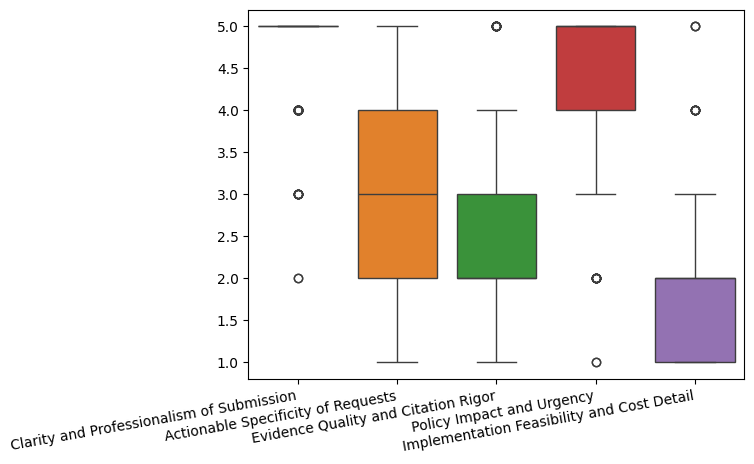

In [45]:
cols = [
    'Clarity_and_Professionalism_of_Submission_gpt-5-mini',
    'Actionable_Specificity_of_Requests_gpt-5-mini',
    'Evidence_Quality_and_Citation_Rigor_gpt-5-mini',
    'Policy_Impact_and_Urgency_gpt-5-mini',
    'Implementation_Feasibility_and_Cost_Detail_gpt-5-mini'
]
colnames = list(map(lambda x: x.replace('gpt-5-mini', '').replace('_', ' ').strip(), cols))
ax = sns.boxplot(dataset_epa.dataframe[cols])
ax.set_xticklabels(colnames, rotation=10, horizontalalignment='right');

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, f1_score

In [49]:
train_df, test_df = train_test_split(dataset_epa.dataframe, test_size=.1)

In [55]:
lr = LogisticRegressionCV()

In [56]:
lr.fit(train_df[cols], train_df['c'])

,Cs,10
,fit_intercept,True
,cv,None
,dual,False
,penalty,'l2'
,scoring,None
,solver,'lbfgs'
,tol,0.0001
,max_iter,100
,class_weight,None
,n_jobs,None


In [60]:
y_proba = lr.predict_proba(test_df[cols])[:, 1]

In [62]:
roc_auc_score(test_df["c"], y_proba)

0.32999999999999996

In [65]:
f1_score(test_df["c"], y_proba > .5)

0.48

In [66]:
# Correlation with human scores: 0.200 (p=0.004)

In [ ]:
test_df["c"]